In [1]:
import torch
import torchvision
import numpy
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/',download = True, transform = ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 141075211.38it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 17676301.45it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 87722816.37it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3721533.26it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Image shape torch.Size([1, 28, 28])
Label 5


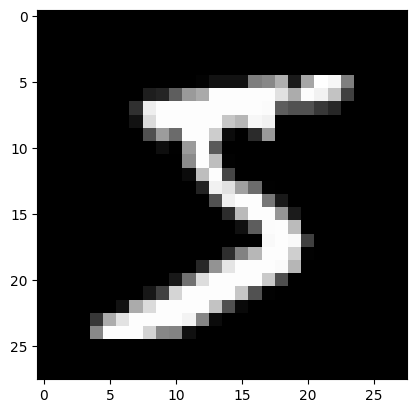

In [3]:
image,label = dataset[0]

print('Image shape',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label',label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size * 2, num_workers =4 ,pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


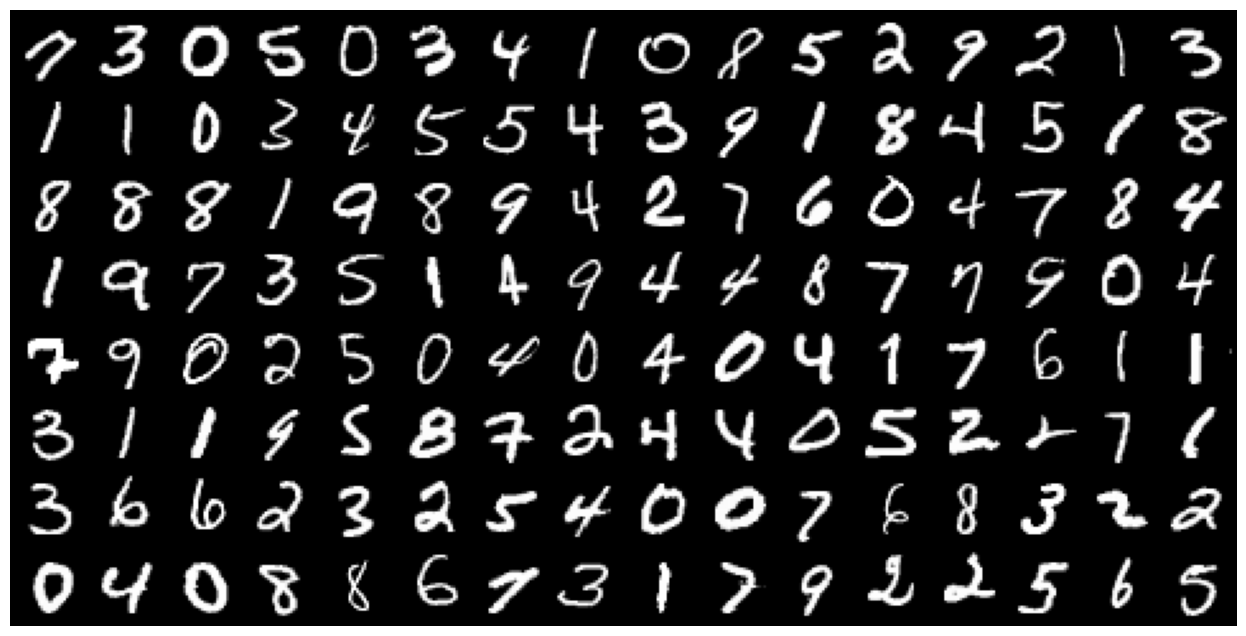

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
class MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    #hidden layer
    self.linear1 = nn.Linear(in_size,hidden_size)
    #output layer
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    #flatten
    xb = xb.view(xb.size(0),-1)

    out = self.linear1(xb)

    out = F.relu(out)

    out = self.linear2(out)

    return out


  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)

    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
input_size = 784
hidden_size = 32
num_classes = 10

In [13]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [14]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [15]:
torch.cuda.is_available()

False

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [21]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


xb.device: cpu
yb: tensor([5, 7, 9, 3, 1, 0, 1, 5, 7, 6, 5, 0, 1, 8, 3, 3, 2, 2, 6, 1, 1, 9, 0, 5,
        4, 8, 1, 3, 6, 6, 7, 5, 3, 7, 6, 4, 3, 7, 2, 9, 9, 7, 8, 5, 3, 1, 1, 6,
        9, 9, 0, 1, 9, 0, 8, 6, 1, 5, 2, 5, 2, 0, 9, 9, 7, 5, 9, 4, 0, 6, 4, 2,
        7, 2, 4, 6, 1, 4, 9, 6, 5, 2, 4, 8, 7, 0, 8, 1, 9, 7, 1, 4, 9, 8, 9, 3,
        1, 3, 5, 7, 1, 8, 7, 2, 0, 0, 3, 9, 4, 8, 8, 9, 1, 4, 3, 2, 3, 2, 3, 8,
        7, 8, 1, 1, 8, 0, 1, 3, 8, 1, 8, 6, 8, 5, 7, 2, 6, 1, 8, 6, 4, 8, 6, 5,
        5, 9, 6, 4, 2, 1, 6, 6, 2, 2, 4, 9, 2, 7, 9, 4, 3, 0, 6, 4, 7, 4, 3, 0,
        6, 4, 8, 1, 2, 0, 4, 2, 4, 2, 9, 5, 8, 0, 2, 3, 3, 4, 7, 9, 0, 6, 1, 7,
        4, 3, 1, 5, 6, 5, 6, 7, 0, 3, 7, 2, 0, 2, 9, 2, 5, 9, 1, 4, 4, 4, 6, 0,
        3, 0, 0, 3, 9, 2, 3, 4, 8, 7, 1, 6, 0, 3, 3, 8, 6, 8, 3, 1, 1, 3, 5, 0,
        3, 1, 9, 5, 9, 6, 1, 2, 3, 3, 8, 2, 8, 7, 6, 0])


In [22]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3119590282440186, 'val_acc': 0.08779297024011612}]

In [25]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2491, val_acc: 0.9297
Epoch [1], val_loss: 0.1799, val_acc: 0.9499
Epoch [2], val_loss: 0.1694, val_acc: 0.9532
Epoch [3], val_loss: 0.1378, val_acc: 0.9623
Epoch [4], val_loss: 0.1459, val_acc: 0.9596


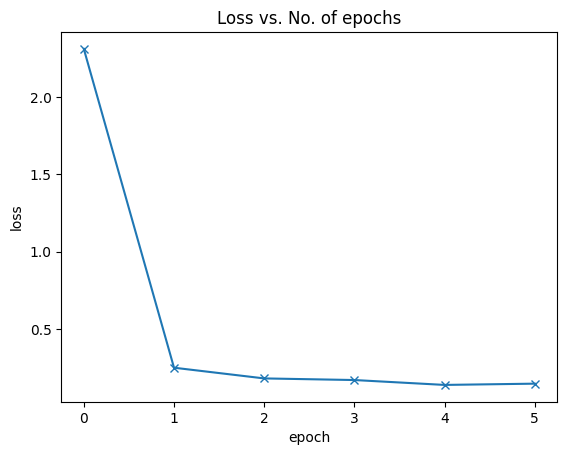

In [26]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

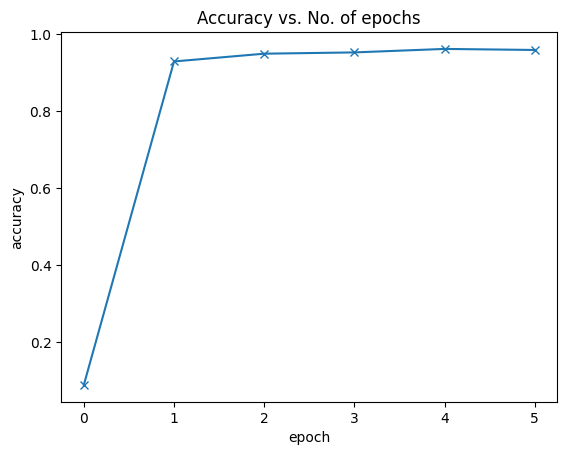

In [27]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');